In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
from mpl_toolkits.mplot3d import Axes3D
import xarray as xr

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    print(base)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

ds = xr.open_dataset("../data/critical_3d_zoom_log.nc")

In [17]:
tol = 0.5
c = np.logical_and(ds["match"]> -tol, ds["match"]< tol)
ds["controlled"] = c.astype(np.float64)
ds["controlled"] = ds["controlled"].where(ds["controlled"]==1)

In [18]:
α = np.tile(ds["α"].values[:, np.newaxis, np.newaxis], (1, 400, 400))
β = np.tile(ds["β"].values[np.newaxis, :, np.newaxis], (400, 1, 400))
γ = np.tile(ds["γ"].values[np.newaxis, np.newaxis, :], (400, 400, 1))

Text(0.5, 0, '$\\gamma$')

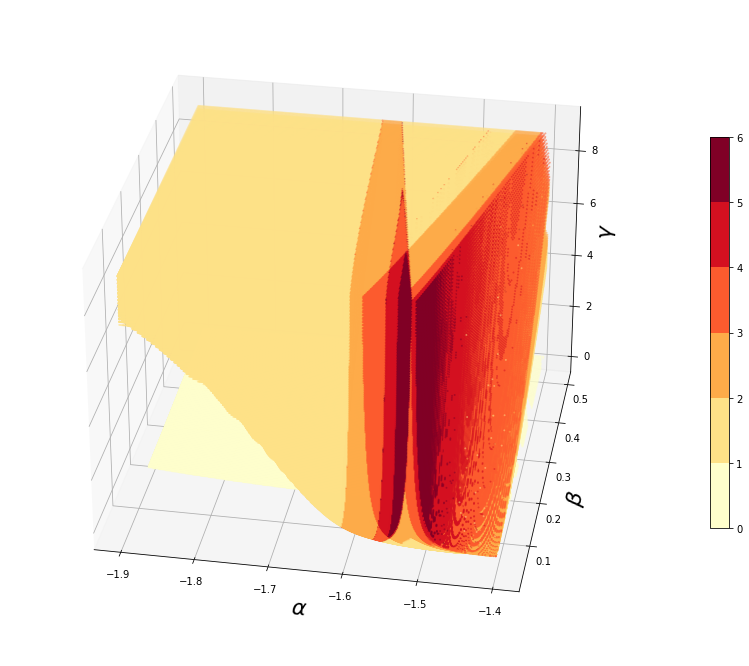

In [19]:
fig = plt.figure(figsize=(18,12))
ax = plt.subplot(projection='3d')
sc = ax.scatter(xs=α[c].flatten(),ys=β[c].flatten(),zs=γ[c].flatten(),
           s=15,c=ds["mode"].values[c].flatten(),
           cmap=discrete_cmap(6,'YlOrRd'),vmin=0,vmax=6,
           marker='.',linewidth=0,alpha=0.5)
sc = ax.scatter(xs=[-1.8,-1.8],ys=[0.1,0.1],zs=[0.1,0.1],
           s=100,c=[1,1],
           cmap=discrete_cmap(6,'YlOrRd'),vmin=0,vmax=6,
           marker='.',linewidth=0,alpha=1.0)
fig.colorbar(sc,shrink=0.6)
sc.remove()
ax.view_init(30, -80)
ax.set_xlabel(r'$\alpha$',fontsize=22)
ax.set_ylabel(r'$\beta$',fontsize=22)
ax.set_zlabel(r'$\gamma$',fontsize=22)

#plt.savefig('nonzero_3d_regime.png',bbox_inches='tight',dpi=400)

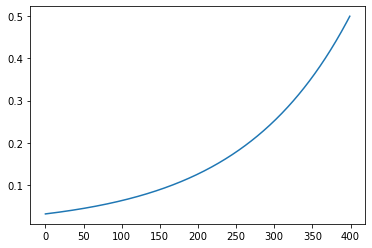

In [20]:
plt.plot(ds['β'])

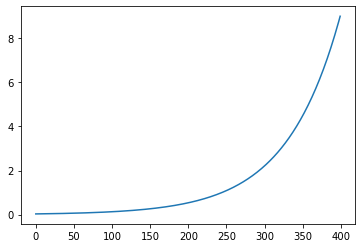

In [21]:
plt.plot(ds['γ'])

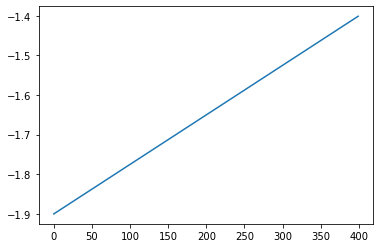

In [22]:
plt.plot(ds['α'])

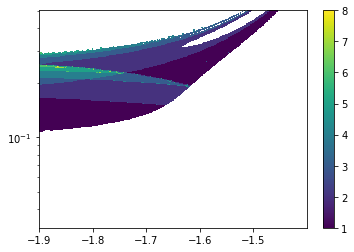

In [23]:
plt.pcolor(ds['α'], ds['β'], ds["mode"].where(c.astype(np.float64)==1).values[:, :, 300])
plt.colorbar()
plt.yscale("log")

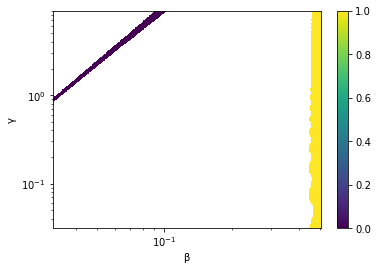

In [24]:
plt.pcolor(ds["β"], ds['γ'], ds["mode"].where(c.astype(np.float64)==1).values[0, :, :])
plt.colorbar()
plt.xlabel("β")
plt.ylabel("γ")
plt.xscale("log")
plt.yscale("log")

In [35]:
plt.contourf(ds["β"], ds['γ'], np.transpose(ds["mode"].where(c.astype(np.float64)==1).values[-97, :, :]), levels=np.arange(-1, 10))
plt.colorbar()
plt.xlabel("β")
plt.ylabel("γ")
plt.xscale("log")
plt.yscale("log")
plt.xlim(2e-1, 5e-1)
plt.ylim(4e-2, 1)

ValueError: operands could not be broadcast together with shapes (40,40) (400,400,400) () 

In [26]:
def shoot_2d(α, r, nx=200, nβ=40, nγ=40):
    βs = np.logspace(np.log10(2e-1), np.log10(5e-1), num=nβ)
    γs = np.logspace(np.log10(4e-2), np.log10(1), num=nγ)
    
    match = np.zeros((nβ,nγ))
    Q = np.zeros((nβ,nγ))
    mode = np.zeros((nβ,nγ))
    zp = np.zeros((nβ,nγ,nx))
    for jj, β in enumerate(βs):
        for kk, γ in enumerate(γs):
            outputs = shoot_perturbations(α, β, γ, r, nx)
            match[jj,kk] = outputs['match']
            Q[jj,kk] = outputs['Q']
            mode[jj,kk] = outputs['mode']
            zp[jj,kk,:] = outputs['zp']
            
    outputs = {
        "βs": βs,
        "γs": γs,
        "match": match,
        "Q": Q,
        "mode": mode,
        "zp": zp,
    }
    return outputs

In [33]:
import channelparams
from shooting import *
from theory import *

fbc = channelparams.fbc.copy()
r = fbc['rsill']
α = ds["α"][200].values
tmp = shoot_2d(α, r)

In [ ]:
plt.contourf(tmp["βs"], tmp['γs'], np.transpose(tmp[""]),levels=np.arange(-1, 10))

(0.04, 1)

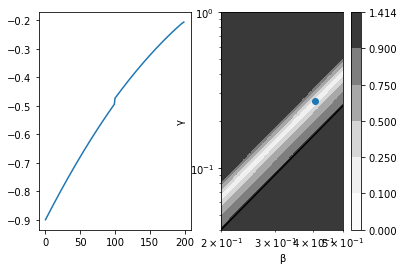

In [53]:
i, j = 30, 23

plt.subplot(1,2,1)
plt.plot(tmp['zp'][i, j])

tol = 0.3

plt.subplot(1,2,2)
c = np.logical_and(tmp["match"]> -tol, tmp["match"]< tol)
modes = tmp["mode"]
modes[c.astype(np.float64)==0] = np.nan
plt.plot(tmp["βs"][i], tmp['γs'][j], "o")
plt.plot(tmp["βs"], tmp["βs"]**2, "k-")
plt.contourf(tmp["βs"], tmp['γs'], np.transpose(tmp["match"]), cmap=plt.get_cmap("Greys"), levels=np.array([0., 0.1, 0.25, 0.5, 0.75, 0.9, np.sqrt(2.)]))
plt.colorbar()
plt.xlabel("β")
plt.ylabel("γ")
plt.xscale("log")
plt.yscale("log")
plt.xlim(2e-1, 5e-1)
plt.ylim(4e-2, 1)

In [230]:
tmp["βs"][i]**2

0.05059363589818043

/var/folders/_7/54nm1vyx6gg9l5f555w0c1tc0000gn/T/ipykernel_63316/2859626596.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


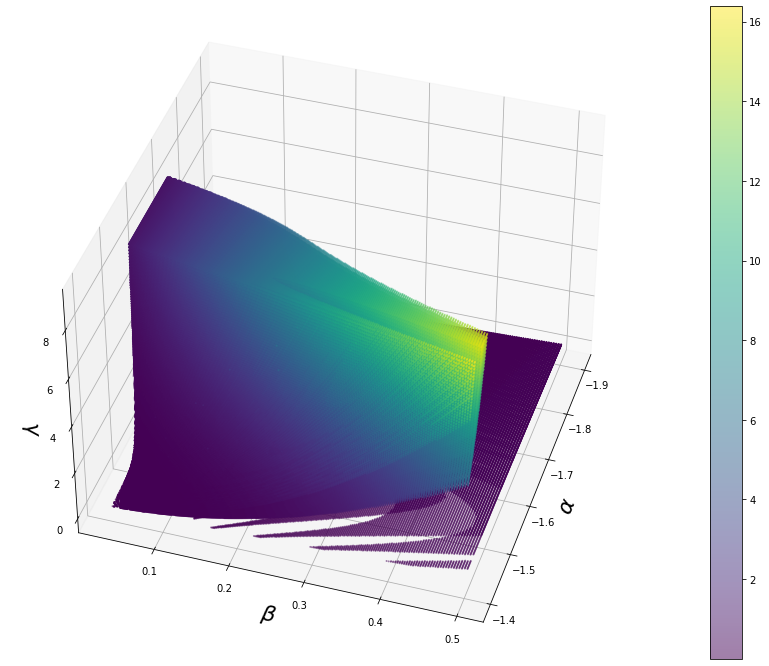

In [52]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(18,12))
ax = plt.subplot(projection='3d')
sc = ax.scatter(xs=α[c].flatten(),ys=β[c].flatten(),zs=γ[c].flatten(),
           s=15,c=ds["Q"].values[c].flatten(),cmap=plt.get_cmap('viridis'),marker='.',linewidth=0,alpha=0.5)
ax.view_init(40, 17.5)
ax.set_xlabel(r'$\alpha$',fontsize=22)
ax.set_ylabel(r'$\beta$',fontsize=22)
ax.set_zlabel(r'$\gamma$',fontsize=22)
plt.colorbar(sc)

plt.savefig('nonzero_3d_regime_Q-color.png',bbox_inches='tight',dpi=400)

# Zooming in

In [ ]:
data = np.load("data/critical_zoom.npz")
print(data.files)
alphas = data["Alphas"]
betas = data["Betas"]
gammas = data["Gammas"]
match = data["match"]

In [ ]:
tol = 0.25
Q = data["Q"]
c = np.logical_and(match<=1+tol, match>=1-tol)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(18,12))
ax = fig.gca(projection='3d')
ax.scatter(xs=alphas[c].flatten(),ys=betas[c].flatten(),zs=gammas[c].flatten(),
           s=15,c=Q[c].flatten(),cmap=plt.get_cmap('viridis'),marker='.',linewidth=0,alpha=0.5)
ax.view_init(89, 17.5)
ax.set_xlabel(r'$\alpha$',fontsize=22)
ax.set_ylabel(r'$\beta$',fontsize=22)
ax.set_zlabel(r'$\gamma$',fontsize=22)
plt.colorbar(sc)

plt.savefig('nonzero_3d_regime_zoom.png',bbox_inches='tight',dpi=400)

# Shooting method at 1D slice & higher modes

#### Uniform PV

$r=0.6$

$\alpha = -\frac{1}{2}(1+\frac{2}{r}) = -2.167$

$\gamma = 0.5$

In [ ]:

data_1d = np.load("data/critical_1d_uniform_PV.npz")
print(data.files)
betas_1d = data_1d["betas"]
match_1d = data_1d["match"]

tol=0.25
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.fill_between([0,1],[1-tol,1-tol],[1+tol,1+tol],color="lightgrey")
plt.plot(betas_1d,match_1d,"r.",markersize=1,alpha=0.1)
plt.ylim([-5,5])
plt.xlim([0,1])
plt.xlabel(r'$\beta$')

plt.subplot(1,2,2)
plt.fill_between([0,1],[1-tol,1-tol],[1+tol,1+tol],color="lightgrey")
plt.plot(betas_1d,match_1d,"r.",markersize=1,alpha=0.1)
plt.ylim([0.5,1.5])
plt.xlim([0.65,0.75])
plt.xlabel(r'$\beta$')

plt.savefig('zeroPV_1d_regime.png',bbox_inches='tight',dpi=400)

#### Non-uniform PV

$r=0.6$

$\alpha = -\frac{1}{2}(1+\frac{2}{r}) = -1.65$

$\gamma = 0.5$

In [ ]:

data_1d = np.load("data/critical_1d_nonuniform_PV.npz")
print(data.files)
betas_1d = data_1d["betas"]
match_1d = data_1d["match"]

tol=0.25
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.fill_between([0,1],[1-tol,1-tol],[1+tol,1+tol],color="lightgrey")
plt.plot(betas_1d,match_1d,"r.",markersize=1)
plt.ylim([-5,5])
plt.xlim([0,1])
plt.xlabel(r'$\beta$')

plt.subplot(1,2,2)
plt.fill_between([0,1],[1-tol,1-tol],[1+tol,1+tol],color="lightgrey")
plt.plot(betas_1d,match_1d,"r.",markersize=1)
plt.ylim([-2,2])
plt.xlim([0,0.05])
plt.xlabel(r'$\beta$')

plt.savefig('nonzeroPV_1d_regime.png',bbox_inches='tight',dpi=400)